# 1. Импорт библиотек

In [139]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import re
import math
import itertools
from tabulate import tabulate

import scipy.stats as stats
from scipy.stats import shapiro

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white

from sklearn.linear_model import LinearRegression

# 2. Импорт данных и проверка

In [140]:
data = pd.read_csv('gold_apple_data.csv')

In [141]:
data.shape

(7817, 5)

In [142]:
data.dtypes

,0
product_id,int64
price,int64
rating,float64
review_count,int64
composition,object


In [143]:
data.head(10)

,product_id,price,rating,review_count,composition
0,19000003101,6232,5.0,5,"AQUA, GLYCERIN, PROPANEDIOL, ISOHEXADECANE, CY..."
1,19000130924,141,5.0,3,"Aqua, Kaolin, Magnesium Aluminum Silicate, Gly..."
2,19000114175,1866,4.2,5,"Термальная Вода Урьяж, Мицеллы, Экстракт Клюкв..."
3,60220100051,80,5.0,1,"water, glycerin, butylene glycol, propylene gl..."
4,19000176868,2685,5.0,6,"Water, Dipropylene Glycol, Glycerin, Propanedi..."
5,19000037246,299,5.0,2,"Aqua (Deionized), Vegetable Glycerin, D-panthe..."
6,19000011284,3180,4.7,25,WATER(AQUA/EAU)･DIPROPYLENE GLYCOL･ALCOHOL DEN...
7,15020300027,9100,4.8,40,AQUA/WATER/EAU. CETEARYL ISONONANOATE. GLYCERI...
8,19000054810,332,4.5,2,"Deionized Water, Hydroxyethyl Acrylate (and) S..."
9,19000005659,135,5.0,9,"AQUA / WATER, GLYCERIN, BETAINE, RHAMNOSE, ALU..."


Всего 7817 объектов, с типами столбцов всё хорошо. Проверим, что все объекты уникальны.

In [144]:
data.product_id.nunique()

7817

Проверим, что в таблице нет пустых значений (в том числе нет значений стоимости, равных нулю). При этом значения рейтинга, равные нулю, допускаются, только если на этот продукт нет отзывов.

In [145]:
data.isnull().sum().iloc[0]

0

In [146]:
data[['composition']].query('composition == ""').count().iloc[0]

0

In [147]:
data[['price', 'rating', 'review_count']].describe()

,price,rating,review_count
count,7817.000000,7817.000000,7817.000000
mean,2433.237303,3.146424,10.119867
std,5432.946195,2.121237,31.462327
min,29.000000,0.000000,0.000000
25%,414.000000,0.000000,0.000000
50%,1008.000000,4.300000,2.000000
75%,2440.000000,4.800000,9.000000
max,160947.000000,5.000000,1061.000000


In [148]:
data.query("rating == 0.0").equals(data.query("review_count == 0"))

True

# 3. EDA или предварительный анализ данных

## 3.1. Посмотрим на распределения зависимых переменных и удалим выбросы

### 3.1.0. Немного вспомогательных функций

In [149]:
sns.set_theme()

In [150]:
def hist_with_two_range_clarification(array_data, name_column, cnt_bins, array_title):
    plt.rcParams['figure.figsize'] = (6, 4)
    _, axs = plt.subplots(1, 2)
    for i in range(2):
      axs[i].hist(array_data[i][name_column], bins=cnt_bins)
      axs[i].set_title(array_title[i])

In [151]:
def hist_with_four_range_clarification(array_data, name_column, cnt_bins, array_title):
    plt.rcParams['figure.figsize'] = (12, 4)
    _, axs = plt.subplots(1, 4)
    for i in range(4):
      axs[i].hist(array_data[i][name_column], bins=cnt_bins)
      axs[i].set_title(array_title[i])

In [152]:
def hist_and_boxplot(df_data, name_column, title):
    plt.rcParams['figure.figsize'] = (6, 4)
    _, axs = plt.subplots(1, 2)
    axs[0].hist(df_data[name_column], bins=12)
    axs[0].set_title(title)
    axs[1].boxplot(df_data[name_column])

In [153]:
def hist_and_qq_plot(list_data):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6))
    ax1.hist(list_data, bins=30, density=True, alpha=0.6, color='g')

    xmin, xmax = ax1.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, np.mean(list_data), np.std(list_data))
    ax1.plot(x, p, 'k', linewidth=2)
    ax1.set_title('Гистограмма')
    ax1.set_xlabel('Значения')
    ax1.set_ylabel('Плотность вероятности')

    stats.probplot(list_data, dist="norm", plot=ax2)
    ax2.set_title('QQ-plot')

    theoretical_quantiles = ax2.get_lines()[0].get_xdata()
    sample_quantiles = ax2.get_lines()[0].get_ydata()
    correlation_coefficient = np.corrcoef(theoretical_quantiles, sample_quantiles)[0, 1]
    plt.figtext(0.5, 0.01, f'Коэффициент корреляции: {correlation_coefficient:.4f}', ha='center', fontsize=12)

In [154]:
def plot_with_log(df_data, name_column, title):
    plt.rcParams['figure.figsize'] = (12, 4)
    _, axs = plt.subplots(1, 4)

    temp_data = df_data
    axs[0].hist(temp_data[name_column], bins=12)
    axs[0].set_title(title)
    axs[1].boxplot(temp_data[name_column])

    temp_log = temp_data[name_column].apply(lambda x: math.log(x))
    axs[2].hist(temp_log, bins=12)
    axs[2].set_title('log')
    axs[3].boxplot(temp_log)

In [155]:
def borders_of_outliers(series_data, log = False):
  temp_data = series_data
  if log:
      temp_data = temp_data.apply(lambda x: math.log(x))

  percentile_25 = temp_data.quantile(0.25)
  percentile_75 = temp_data.quantile(0.75)
  IQR = percentile_75 - percentile_25
  left_border = percentile_25 - 1.5 * IQR
  right_border = percentile_75 + 1.5 * IQR

  count_under_left = temp_data.where(temp_data < left_border).sum()
  count_upper_right = temp_data.where(temp_data > right_border).sum()
  if log:
    return tabulate([
        ['Границы выбросов log', left_border, right_border],
        ['Границы выбросов NOT log', math.exp(left_border), math.exp(right_border)],
        ['Количество значений за границей', count_under_left, count_upper_right]
        ], headers=['Показатели', 'Левая', 'Правая'])
  else:
    return tabulate([
        ['Границы выбросов', left_border, right_border],
        ['Количество значений за границей', count_under_left, count_upper_right]
        ], headers=['Показатели', 'Левая', 'Правая'])


### 3.1.1. Стоимость

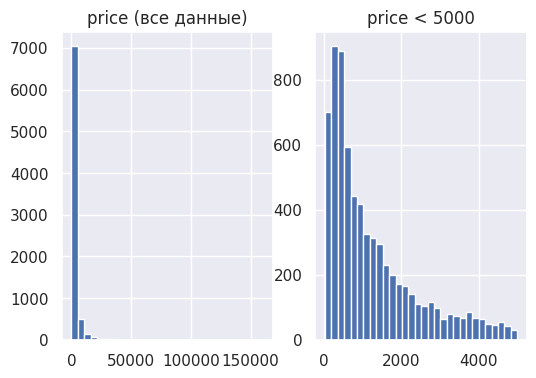

In [156]:
hist_with_two_range_clarification([data, data[data['price'] < 5000]],
                                  'price', 30,
                                  ['price (все данные)', 'price < 5000'])

Похоже на логнормальное распредление.

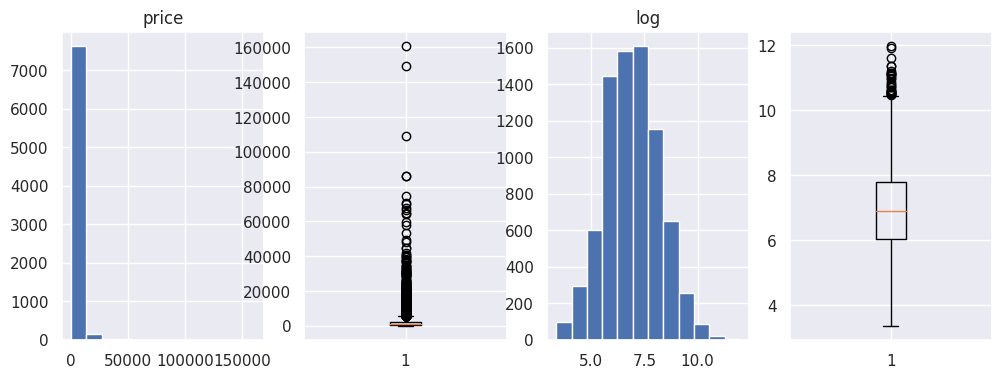

In [157]:
plot_with_log(data, 'price', 'price')

Надо удалить выбросы.

In [158]:
print(borders_of_outliers(data['price'], log=True))

Показатели                          Левая      Правая
-------------------------------  --------  ----------
Границы выбросов log              3.36503     10.4606
Границы выбросов NOT log         28.9345   34911.9
Количество значений за границей   0          338.66


In [159]:
data = data[(data['price'] >= 30) & (data['price'] <= 34000)]

In [160]:
print(borders_of_outliers(data['price'], log=True))

Показатели                          Левая      Правая
-------------------------------  --------  ----------
Границы выбросов log              3.37468     10.4283
Границы выбросов NOT log         29.2151   33804.4
Количество значений за границей   0            0


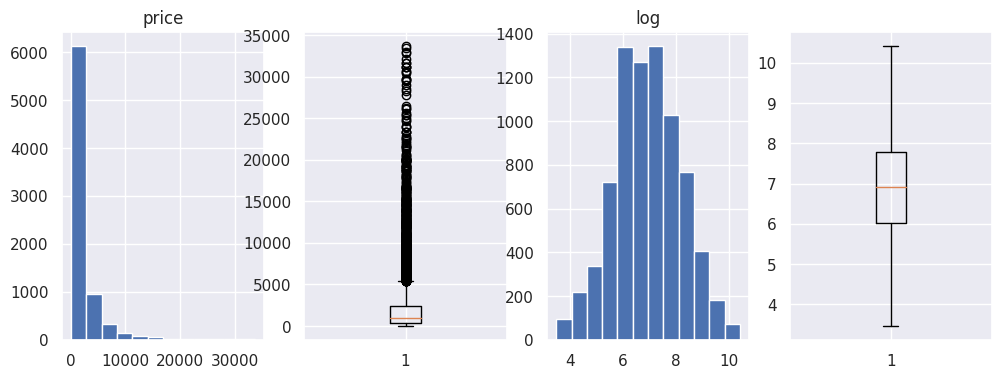

In [161]:
plot_with_log(data, 'price', 'price')

Теперь красота!

Оставили для анализа только те продукты, стоимость которых хотя бы 30 и не более 34000.

Добавим так же в датафрейм логарифм цены.

In [162]:
data = data.assign(price_log=lambda x: np.log(x.price))
data.head()

,product_id,price,rating,review_count,composition,price_log
0,19000003101,6232,5.0,5,"AQUA, GLYCERIN, PROPANEDIOL, ISOHEXADECANE, CY...",8.737453
1,19000130924,141,5.0,3,"Aqua, Kaolin, Magnesium Aluminum Silicate, Gly...",4.948760
2,19000114175,1866,4.2,5,"Термальная Вода Урьяж, Мицеллы, Экстракт Клюкв...",7.531552
3,60220100051,80,5.0,1,"water, glycerin, butylene glycol, propylene gl...",4.382027
4,19000176868,2685,5.0,6,"Water, Dipropylene Glycol, Glycerin, Propanedi...",7.895436


In [163]:
print(data['price_log'].mean())

6.916263106591507


### 3.1.2. Рейтинг

Сначала посмотрим, как выглядит распределение количества отзывов, ведь как минимум не все продукты были оценены.

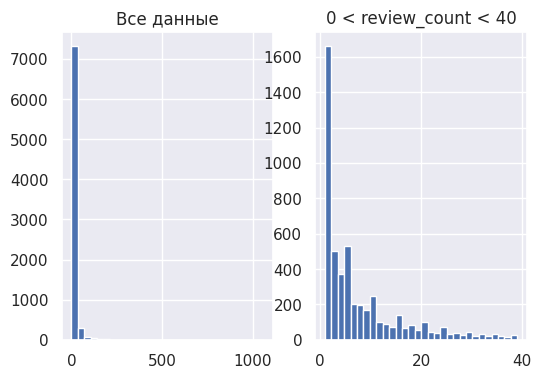

In [164]:
hist_with_two_range_clarification([data, data[(data['review_count'] > 0) & (data['review_count'] < 40)]],
                                  'review_count', 30,
                                   ['Все данные', '0 < review_count < 40'])

Рейтинг продукта - это значение от 1 до 5 (во время парсинга значение 0 было зарезервированным значением для заполнения поля rating тех продуктов, на которых нет ни одного отзыва). Так что можем рассматривать только значения, не меньшие одного.

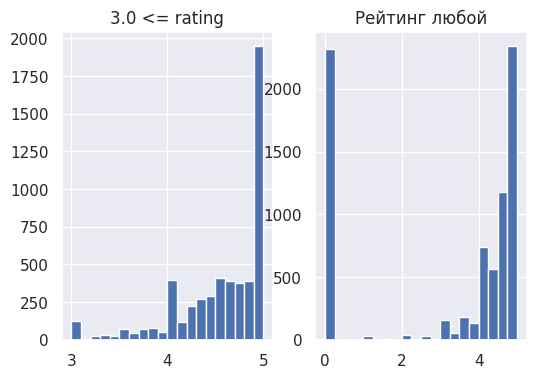

In [165]:
hist_with_two_range_clarification([data[data['rating'] >= 3.0], data],
                                  'rating', 20,
                                  ['3.0 <= rating', 'Рейтинг любой'])

Сразу заметно, что расспределние рейтинга очень необычное.

In [166]:
data.query('rating > 0.0').count().iloc[0]

5465

In [167]:
data.query('rating > 0.0').query('rating < 4.0').count().iloc[0] / data.query('rating > 0.0').count().iloc[0]

0.11765782250686185

Мало продуктов с рейтингом, меньшим четырех (всего 12% от всех оцененных).

In [168]:
data.query('rating == 5.0').count().iloc[0] / data.query('rating > 0.0').count().iloc[0]

0.32186642268984444

Тем временем количество продуктов с рейтингом 5.0 составляет 32% от всех оцененных продуктов.

Посмотрим на распределения рейтинга тех продуктов, которые оценили больше чем $X = \{0, 5, 10, 30\}$ человек.

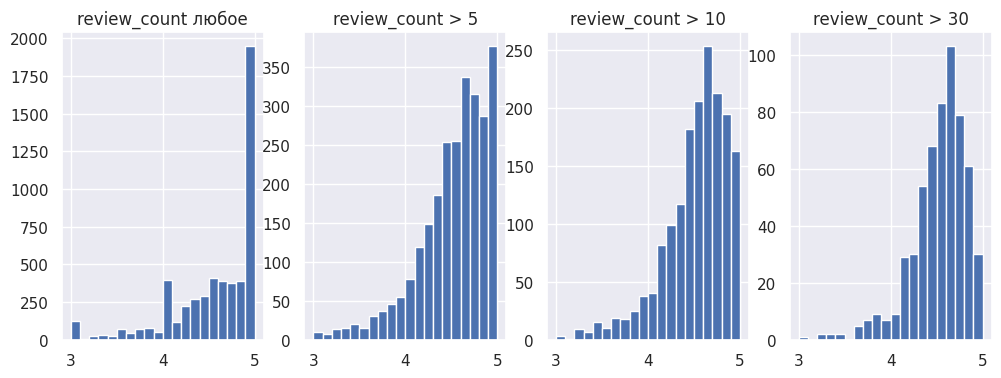

In [169]:
hist_with_four_range_clarification([data[(data['rating'] >= 3.0)],
                               data[(data['rating'] >= 3.0) & (data['review_count'] > 5)],
                               data[(data['rating'] >= 3.0) & (data['review_count'] > 10)],
                               data[(data['rating'] >= 3.0) & (data['review_count'] > 30)]],
                               'rating', 20,
                               ['review_count любое', 'review_count > 5', 'review_count > 10', 'review_count > 30'])

Можно предположить, что при увелечении границы Review_Count распределние рейтинга продуктов становится более похожим на нормальное со сдвигом.

Понятно, что не стоит проводить анализ влияния компонентов на рейтинг без оговорки на то, что рейтинг должен быть *достоверный*. То есть в анализе должны рассматриваться только продукты с колчичеством оценок большим некого $N$.

Посмотрим на box-plot при $N = 10$.

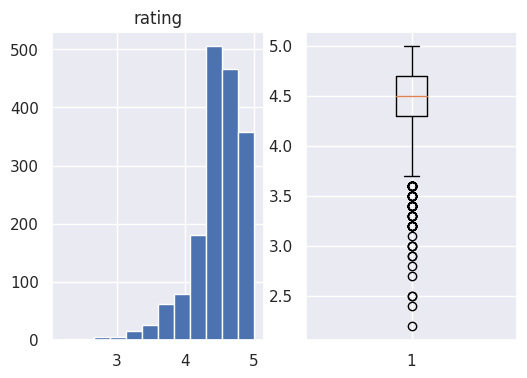

In [170]:
temp_data_10 = data[data['review_count'] > 10]
hist_and_boxplot(temp_data_10, 'rating', 'rating')

In [171]:
print(borders_of_outliers(temp_data_10['rating']))

Показатели                         Левая    Правая
-------------------------------  -------  --------
Границы выбросов                     3.7       5.3
Количество значений за границей    239.3       0


Еще интересно, что внутри каталога золотого яблока так же присутсвует часто встречающаяся в последнее время в мире "инфляция оценок".


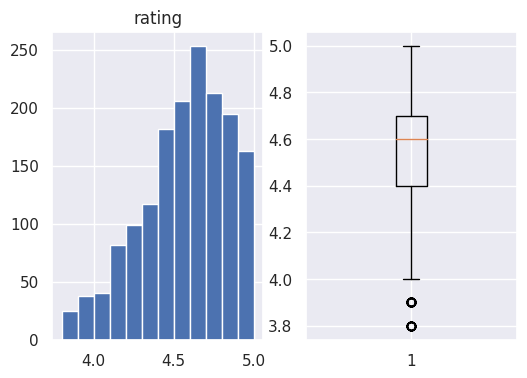

In [172]:
temp_data_10 = temp_data_10[temp_data_10['rating'] > 3.7]
hist_and_boxplot(temp_data_10, 'rating', 'rating')

In [173]:
print(temp_data_10['rating'].mean())

4.51965282083075


In [174]:
print(temp_data_10['rating'].mode())

0    4.6
Name: rating, dtype: float64


Если же $ N = 30$:

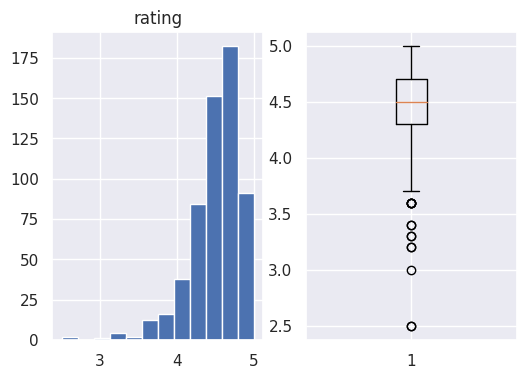

In [175]:
temp_data_30 = data[data['review_count'] > 30]
hist_and_boxplot(temp_data_30, 'rating', 'rating')

In [176]:
print(borders_of_outliers(temp_data_30['rating']))

Показатели                         Левая    Правая
-------------------------------  -------  --------
Границы выбросов                     3.7       5.3
Количество значений за границей     45.8       0


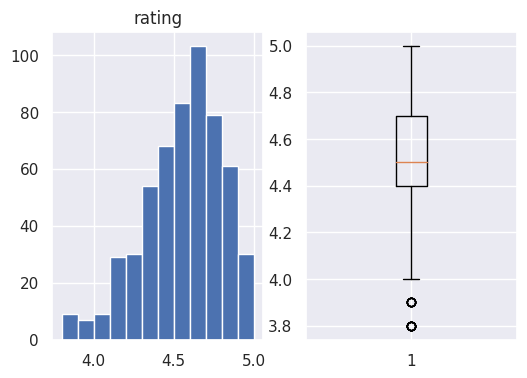

In [177]:
temp_data_30 = temp_data_30[temp_data_30['rating'] > 3.7]
hist_and_boxplot(temp_data_30, 'rating', 'rating')

In [178]:
print(temp_data_30['rating'].mean())

4.5062277580071175


In [179]:
print(temp_data_30['rating'].mode())

0    4.6
Name: rating, dtype: float64


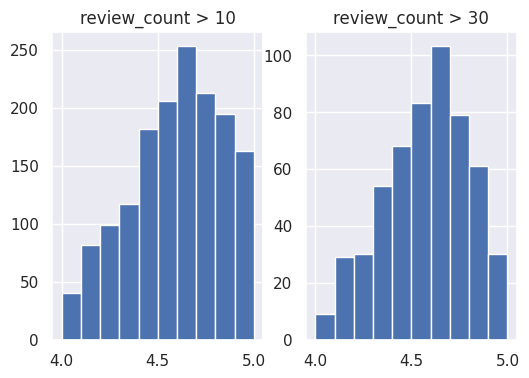

In [180]:
hist_with_two_range_clarification([
    temp_data_10[temp_data_10['rating'] >= 4.0],
    temp_data_30[temp_data_30['rating'] >= 4.0],
                                  ], 'rating', 10, ['review_count > 10', 'review_count > 30'])

Таким образом можем выделить четыре границы:
1. по количеству отзывов:
  *   более мягкая: review_count > 10
  *   более жесткая: review_count > 30
2. по рейтингу (целевая переменная):
  *   более мягкая: rating > 3.6
  *   более жесткая: rating >= 4.0.

Выбросы отсутвуют и при более мягких границах, однако более жесткие границы приближают распределение зависимой переменной к нормальному, хотя и сужают диапазон анализа.

Срезать данные пока не будем, так как есть план посмотреть сначала на влияние отдельных активных компонентов только на стоимость, а для этого стоит оставить релевантные по стоимости данные. В пункте 5 определим наилучний диапазон фильтрации данных.


### 3.1.3. Связь между рейтингом и ценой?

Теперь с известными ограничениями посмотрим на связь рейтинга и цены.

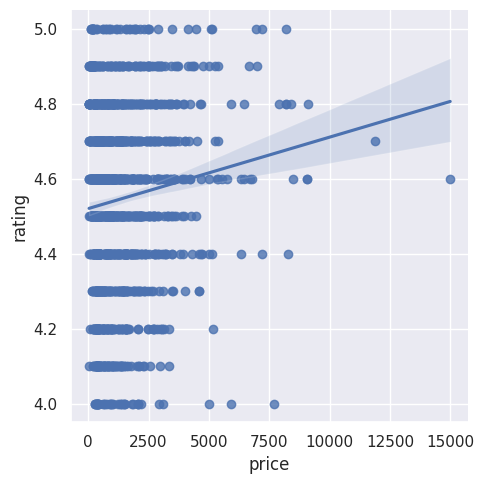

In [181]:
sns.lmplot(data=data[(data['rating'] >= 4.0) & (data['review_count'] > 10)], x='price', y='rating')

Может быть есть небольшая положительная корреляция между рейтингом продукта и его ценой, но пока рано говорить об этом.

Посмотрим на средние стоимости в зависимости от рейтинга.

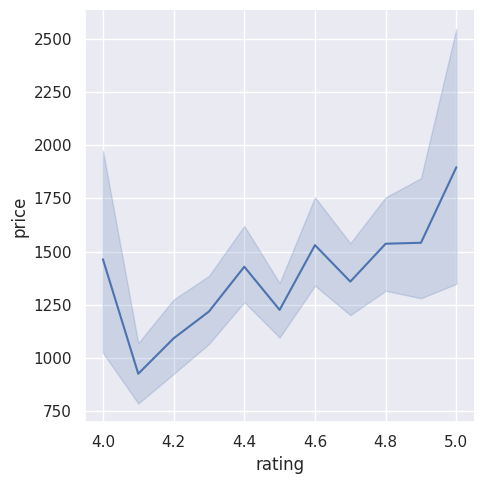

In [182]:
sns.relplot(data=data[(data['rating'] >= 4.0) & (data['review_count'] > 10)], kind='line', x='rating', y='price')

## 3.2 Предобработка независимых переменных для анализа

### 3.2.1. Cоздание номинативных переменных наличия в составе активных компонентов

Начальный список активных компонентов в уходовой косметике (относительно которых будет проводиться анализ):
1. vitamin C
2. vitamin E
3. retinol (витамин A)
4. hyaluronic acid (гиалуроновая кислота)
5. kojic acid (койевая кислота)
6. azelaic acid (азелаиновая кислота)
7. lactic acid (молочная кислота, подвид AHA-кислот)
8. mandelic (мидальная кислота, подвид AHA-кислот)
9. glycolic acid (гликолевая кислота, подвид AHA-кислот)
10. salicylic acid (cалициловая кислота, подвид BHA-кислот)
11. glycerin (глицерин)
12. ceramide (церамид)
13. peptide (пептид)
14. paraben (парабен)
15. niacinamide (ниацинамид)
16. zinc (цинк)

При этом витамины имеют несколько производных форм, в виде которых могут быть указаны в составе продукта.

Vitamin C:
1. Ascorbic Acid / L-Ascorbic Acid / Аскорбиновая кислота
2. Ascorbyl Glucoside / Аскорбил глюкозид
3. Tetrahexyldecyl Ascorbate / Тетрагексилдецил аскорбат
4. Magnesium Ascorbyl Phosphate / Аскорбилфосфат магния
5. Sodium Ascorbyl Phosphate / Аскорбилфосфат натрия
6. Ascorbyl Tetraisopalmitate / Аскорбил тетраизопальмитат
7. Ascorbyl Palmitate /  Аскорбил пальмитат
8. 3-O-Ethyl Ascorbic Acid / 3-O-этил-аскорбат

Vitamin E:
1. Tocopherol Tocopheryl Acetate / Токоферола ацетат
2. Tocopheryl Glucoside / Токоферола глюкозид
3. Tocopheryl Linoleate / Токоферола линолеат

Retinol (vitamin A):
1. Retinol acetate / Ретинол ацетат
2. Retinol palmitate / Ретинола пальмитат
3. Retinaldehyde / Ретинальдегид (ретиналь)


In [183]:
def assign_ingredient_column(derivative_forms, name_column):
  pattern = '|'.join(derivative_forms)
  # case : False - не учитывается регистр
  return data.assign(**{name_column: np.where(data['composition'].str.contains(pattern, case=False), 1, 0)})

Добавим колонку, отвечающую за наличие в составе витамина C.

In [184]:
derivative_forms_vitamin_c = [
    'Vitamin C', 'Ascorbic Acid', 'L-Ascorbic Acid', 'Аскорбиновая кислота',
    'Ascorbyl Glucoside', 'Аскорбил глюкозид', 'Tetrahexyldecyl Ascorbate', 'Тетрагексилдецил аскорбат',
    'Magnesium Ascorbyl Phosphate', 'Аскорбилфосфат магния', 'Sodium Ascorbyl Phosphate', 'Аскорбилфосфат натрия',
    'Ascorbyl Tetraisopalmitate', 'Аскорбил тетраизопальмитат', 'Ascorbyl Palmitate', 'Аскорбил пальмитат',
    '3-O-Ethyl Ascorbic Acid', '3-O-этил-аскорбат'
    ]

data = assign_ingredient_column(derivative_forms_vitamin_c, 'vitamin_c')

Добавим колонку, отвечающую за наличие в составе витамина E.

In [185]:
derivative_forms_vitamin_e = [
    'Vitamin E', 'Tocopherol Tocopheryl Acetate', 'Токоферола ацетат',
    'Tocopheryl Glucoside', 'Токоферола глюкозид', 'Tocopheryl Linoleate', 'Токоферола линолеат'
    ]

data = assign_ingredient_column(derivative_forms_vitamin_e, 'vitamin_e')

Добавим колонку, отвечающую за наличие в составе ретинола.

In [186]:
derivative_forms_retinol = [
    'Retinol', 'vitamin A', 'Retinol acetate', 'Ретинол ацетат',
    'Retinol palmitate', 'Ретинола пальмитат', 'Retinaldehyde', 'Ретинальдегид', 'Retinal', 'Ретиналь',
    'Retinoic Acid', 'Ретиноевая кислота', 'Tretinoin', 'Третиноин'
    ]

data = assign_ingredient_column(derivative_forms_retinol, 'retinol')

Аналогично добавим остальные колонки.

In [187]:
data = assign_ingredient_column(['hyaluronic acid', 'гиалуроновая кислота'], 'hyaluronic_acid')

In [188]:
data = assign_ingredient_column(['kojic acid', 'койевая кислота'], 'kojic_acid')

In [189]:
data = assign_ingredient_column(['azelaic acid', 'азелаиновая кислота'], 'azelaic_acid')

In [190]:
data = assign_ingredient_column(['lactic acid', 'молочная кислота'], 'lactic_acid')

In [191]:
data = assign_ingredient_column(['mandelic acid', 'мидальная кислота'], 'mandelic_acid')

In [192]:
data = assign_ingredient_column(['glycolic acid', 'гликолевая кислота'], 'glycolic_acid')

In [193]:
data = assign_ingredient_column(['salicylic acid', 'cалициловая кислота'], 'salicylic_acid')

In [194]:
data = assign_ingredient_column(['glycerin', 'глицерин'], 'glycerin')

In [195]:
data = assign_ingredient_column(['ceramide', 'церамид'], 'ceramide')

In [196]:
data = assign_ingredient_column(['peptide', 'пептид'], 'peptide')

In [197]:
data = assign_ingredient_column(['paraben', 'парабен'], 'paraben')

In [198]:
data = assign_ingredient_column(['niacinamide', 'ниацинамид'], 'niacinamide')

In [199]:
data = assign_ingredient_column(['zinc', 'цинк'], 'zinc')

In [200]:
data.iloc[:, 7:].sum()

,0
vitamin_e,106
retinol,139
hyaluronic_acid,1128
kojic_acid,7
azelaic_acid,64
lactic_acid,914
mandelic_acid,68
glycolic_acid,336
salicylic_acid,475
glycerin,6209


Сразу удалим столбец kojic_acid, так как выборка по этому компоненту слишком мала.



In [201]:
data = data.drop(columns=['kojic_acid'])

In [202]:
ALL_COMPONENTS = list(data.columns[6:])
print(ALL_COMPONENTS)

['vitamin_c', 'vitamin_e', 'retinol', 'hyaluronic_acid', 'azelaic_acid', 'lactic_acid', 'mandelic_acid', 'glycolic_acid', 'salicylic_acid', 'glycerin', 'ceramide', 'peptide', 'paraben', 'niacinamide', 'zinc']


Посмотрим на матрицу корреляций.


In [203]:
data_components = data.copy().drop(columns=['product_id', 'price', 'price_log', 'rating', 'review_count', 'composition'])

<Axes: >

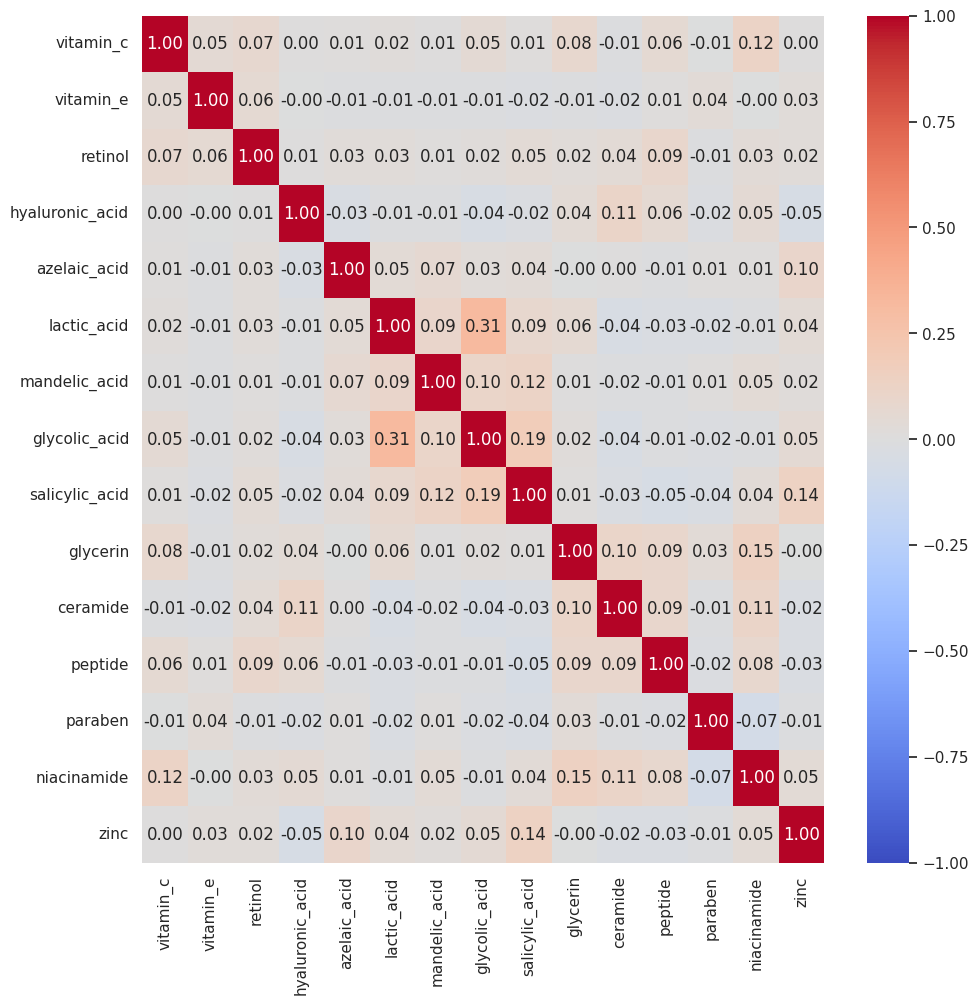

In [204]:
plt.subplots(figsize=(11, 11))
sns.heatmap(data_components.corr(), annot=True, fmt=".2f", vmin=-1, vmax=1, center= 0, cmap='coolwarm')

Переменные почти не коррелируют между собой, всё хорошо.

# 4. Анализ влияния активых компонентов в составе на стоимость

## 4.1. Cтатистическая значимость по t-критерию Стьюдента

Сначала получим все возможные подмножества содержания тех или иных активных компонентов.

Базовым множеством будем называть то подмножество, продукты в котором не содержат ни одного активного компонента. Для оставшихся групп (после проверки на нормальность) и применим одновыборочный  тест Стьюдента относительно среднего логарифма цены базового множества, так как эти множества будут дизъюнкты и будут явно отражать влияние того или тех (в совокупности) компонентов. То есть, например, подмножество, отвечающее за витамин С - множество тех продуктов, которые содержат его и НЕ содержат никакие другие активные компонеты. А подмножество отвечающее за взаимодействие факторов vitamin_c::vitamin_e::retinol будет содержать продукты, в которых есть только эти компоненты.

Итак, профильтруем наши данные по всем подмножествам компонентов.

In [205]:
data.columns

Index(['product_id', 'price', 'rating', 'review_count', 'composition',
       'price_log', 'vitamin_c', 'vitamin_e', 'retinol', 'hyaluronic_acid',
       'azelaic_acid', 'lactic_acid', 'mandelic_acid', 'glycolic_acid',
       'salicylic_acid', 'glycerin', 'ceramide', 'peptide', 'paraben',
       'niacinamide', 'zinc'],
      dtype='object')

! Далее часть операций будет вынесена в отдельные функции, чтобы потом переиспользовать код для анализа влияния на рейтинг.

Избавимся от всех ненужных на данном этапе нам столбцов.

In [206]:
def get_data_on_ingredients_and_dependent_variable(dependent_var):
  unnecessary_cloumns = ['product_id', 'price', 'price_log', 'rating', 'review_count', 'composition']
  unnecessary_cloumns.remove(dependent_var)
  temp_data = data.copy().drop(columns=unnecessary_cloumns)
  return temp_data

In [207]:
data_price = get_data_on_ingredients_and_dependent_variable('price_log')

In [208]:
components = ALL_COMPONENTS.copy()

Создадим датафрейм, в котором для каждой комбинации будет лежать набор стоимостей (если точнее, то логарифмов стоимостей) соотвествющих ей продуктов.

In [209]:
def get_combinations(df_data, curr_components, dependent_var):
  results = []

  combinations = list(itertools.product([0, 1], repeat=len(curr_components)))

  for combo in combinations:
      mask = (df_data[curr_components].values == np.array(combo)).all(axis=1)
      filtered_data = df_data[mask]

      if not filtered_data.empty:
          results.append({
              'combination': np.array(combo),
              dependent_var: filtered_data[dependent_var].tolist()
              })

  return pd.DataFrame(results)

In [210]:
data_price_comb = get_combinations(data_price, components, 'price_log')

In [211]:
data_price_comb.head()

,combination,price_log
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[10.12543038327382, 10.170456583390367, 5.4293..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[6.948897222313312, 9.117127990254003, 7.41034..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[8.430327258394575, 7.81923445385907, 6.146329..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]","[6.184148890937483, 7.596894438144544, 5.79301..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]","[7.124478262493424, 5.153291594497779, 7.31588..."


In [212]:
data_price_comb.shape

(459, 2)

Ненулевых подмножеств получилось 459. Добавим столбец отвечающий за количество продуктов в множестве и удалим те, где cnt_products < 3.

In [213]:
def add_column_cnt_to_data_comb(df_data, dependent_var):
  df_data['cnt_products'] = df_data[dependent_var].apply(len)
  df_data = df_data.drop(df_data[df_data.cnt_products < 3].index)
  return df_data

In [214]:
data_price_comb = add_column_cnt_to_data_comb(data_price_comb, 'price_log')
data_price_comb.shape

(174, 3)

In [215]:
data_price_comb.head()

,combination,price_log,cnt_products
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[10.12543038327382, 10.170456583390367, 5.4293...",865
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[6.948897222313312, 9.117127990254003, 7.41034...",35
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[8.430327258394575, 7.81923445385907, 6.146329...",52
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]","[6.184148890937483, 7.596894438144544, 5.79301...",5
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]","[7.124478262493424, 5.153291594497779, 7.31588...",44


Первая строка с комбинацией [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] является представителем тех продуктов, у которых не выражен ни один признак (у которых нет в составе ни одного из предикторов). Поэтому она является базовым множеством и относительно нее будут проводиться тесты.

In [216]:
def get_base_group(df_data, dependent_var):
  return pd.DataFrame(df_data.iloc[0, :][dependent_var], columns=[dependent_var])

In [217]:
base_group = get_base_group(data_price_comb, 'price_log')

In [218]:
data_price_comb = data_price_comb.drop(index=0)

In [219]:
print(borders_of_outliers(base_group['price_log']))

Показатели                         Левая    Правая
-------------------------------  -------  --------
Границы выбросов                 3.09399   10.7187
Количество значений за границей  0          0


In [220]:
mean_price_log = base_group['price_log'].mean()
print(mean_price_log)

6.9640660178626055


Условием для применения t-критерия является нормальность распределения выборочных средних, что при маленьких выборках означает условие нормальности исходных значений.

Для проверки на нормальность воспульзуемся тестом Шапиро-Уилка (мы можем его использовать, так как количество элементов в выборках невелико). Удалим те множества, в которых распределение логарифма цены не является нормальным.

In [221]:
def filter_normal_distribution(df_data, dependent_var):
  temp_data = df_data
  for ind, row in temp_data.iterrows():
    if shapiro(row[dependent_var]).pvalue < 0.05:
      temp_data = temp_data.drop(index=ind)
  return temp_data

In [222]:
data_price_comb = filter_normal_distribution(data_price_comb, 'price_log')
data_price_comb.shape

(139, 3)

Теперь наконец воспользуемся t-критерием Стьюдента и сравним множества, содержащие некоторые ингредиенты, с базовым средним.

In [223]:
number_pairwise_comparisons = data_price_comb.shape[0] - 1 # Поправка Бонферрони
print(number_pairwise_comparisons)

138


In [224]:
alpha = 0.05 / number_pairwise_comparisons
print(alpha)

0.00036231884057971015


In [225]:
def get_statistically_significant_by_ttest(df_data, dependent_var, mean_var, alpha):
  result = []
  significant_components = set()

  for ind, row in df_data.iterrows():
    if stats.ttest_1samp(row[dependent_var], popmean=mean_var).pvalue < alpha:
      depend_var = pd.DataFrame(row[dependent_var]).mean().iloc[0]

      comb = row['combination']
      curr_components = [components[i] for i in range(len(comb)) if comb[i] == 1]
      significant_components.update(set(curr_components))

      result.append(['::'.join(curr_components), depend_var])


  return [tabulate(result, headers=['components ', dependent_var]), significant_components]

In [226]:
stats_ttest_price_log = get_statistically_significant_by_ttest(data_price_comb, 'price_log', mean_price_log, alpha)
print(stats_ttest_price_log[0])

components                                          price_log
------------------------------------------------  -----------
peptide                                               7.70776
lactic_acid::glycolic_acid::glycerin                  6.33472
vitamin_c::glycerin::peptide                          8.05661
vitamin_c::glycerin::ceramide::peptide                8.69006
vitamin_c::lactic_acid::salicylic_acid::glycerin      8.13033


Получили 5 групп, внутри которых различия в стоимости являются статистическими значимыми.

При этом наличие взаимодействия lactic_acid, glycolic_acid и glycerin значимо снижают стоимость продукта, а в группах peptide, vitamin_c::glycerin::peptide, vitamin_c::glycerin::ceramide::peptide,  vitamin_c::lactic_acid::salicylic_acid::glycerin стоимость выше базовой.

Оставим только компоненты, взаимодействие которых является статистически значимым. И посмотрим на корреляции.

In [227]:
data_price_st = data_price.drop(columns=set(ALL_COMPONENTS).difference(stats_ttest_price_log[1]))

In [228]:
df = pd.DataFrame(data_price_st)
df['group_peptide'] = df['peptide']
df['group_lactic_glycolic_glycerin'] = (df['lactic_acid'] & df['glycolic_acid'] & df['glycerin']).astype(int)
df['group_vitamin_c_glycerin_peptide'] = (df['vitamin_c'] & df['glycerin'] & df['peptide']).astype(int)
df['group_vitamin_c_glycerin_ceramide_peptide'] = (df['vitamin_c'] & df['glycerin'] & df['ceramide'] & df['peptide']).astype(int)
df['group_vitamin_c_lactic_salicylic_glycerin'] = (df['vitamin_c'] & df['lactic_acid'] & df['salicylic_acid'] & df['glycerin']).astype(int)
data_price_st = df[['price_log',
                 'group_peptide',
                 'group_lactic_glycolic_glycerin',
                 'group_vitamin_c_glycerin_peptide',
                 'group_vitamin_c_glycerin_ceramide_peptide',
                 'group_vitamin_c_lactic_salicylic_glycerin']]

<Axes: >

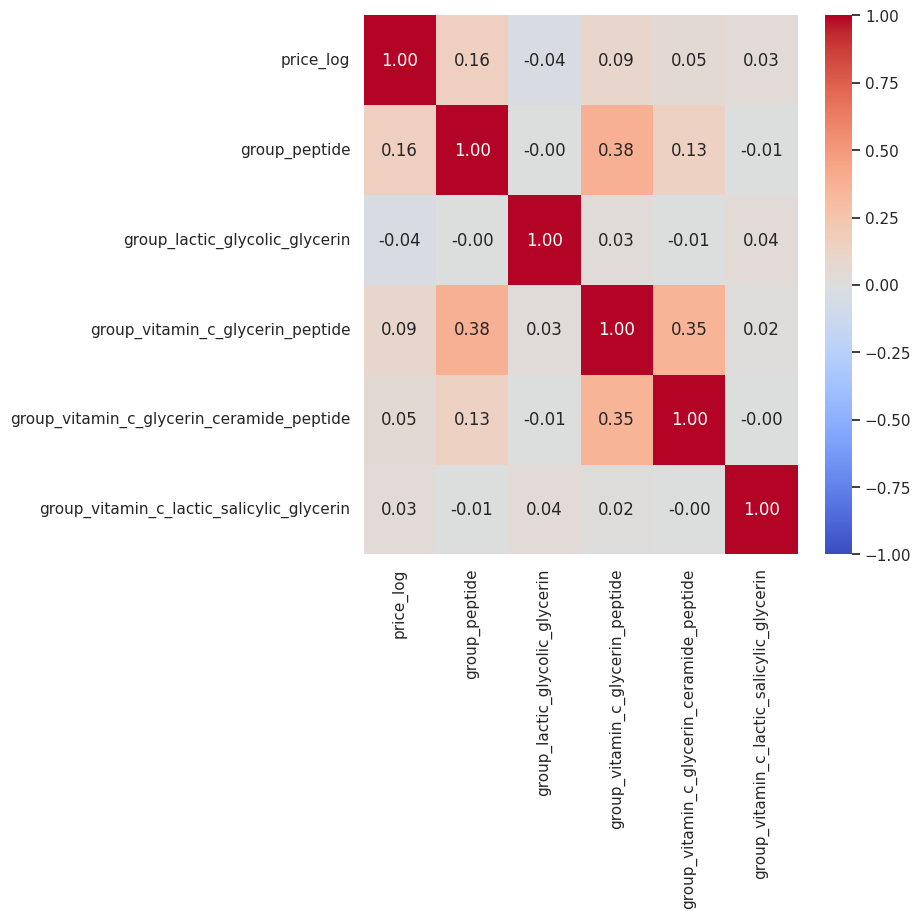

In [229]:
plt.subplots(figsize=(7, 7))
sns.heatmap(data_price_st.corr(), annot=True, fmt=".2f", vmin=-1, vmax=1, center= 0, cmap='coolwarm')

## 4.2 Линейная регрессия

Cначала посмотроим модель на всех активных компонентах, может быть уберем некоторые нерелевантные компоненты, и оценим эту модель. Потом построим модель на множествах взаимодействий компонентов, которые являются статистически значимыми из пункта 4.1. Сравним их и сдлеаем итоговые выводы о влияниии актиных компонентов на цену продукта.

In [230]:
X = data_price.iloc[:, 1:]
y = data_price.iloc[:, 0]
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     33.35
Date:                Fri, 23 Aug 2024   Prob (F-statistic):           7.41e-94
Time:                        00:24:31   Log-Likelihood:                -12636.
No. Observations:                7783   AIC:                         2.530e+04
Df Residuals:                    7767   BIC:                         2.541e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               7.0007      0.032    2

Уберем те компоненты, для которых p_value >= 0.05.


In [231]:
data_price = data_price.drop(columns=['azelaic_acid', 'lactic_acid', 'mandelic_acid', 'glycolic_acid', 'salicylic_acid', 'zinc'])

X = data_price.iloc[:, 1:]
y = data_price.iloc[:, 0]
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     54.25
Date:                Fri, 23 Aug 2024   Prob (F-statistic):           2.35e-96
Time:                        00:24:31   Log-Likelihood:                -12642.
No. Observations:                7783   AIC:                         2.530e+04
Df Residuals:                    7773   BIC:                         2.537e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               6.9993      0.032    2

Теперь для каждого значения p_value < 0.05.

Посмотрим на результаты.
1. Adj. R-squared = 0.058. Данная модель линейной регрессии по заданным независимым переменным описывает всего 5.8% вариаций зависимой переменной.
2. Prob. (F-statistic) - вероятность того, что коэффициенты при всех переменных равны нулю (кроме интерсепта). Prob (F-statistic) = 2.35e-96 < 0.05. Так что можем отклонить нулевую гипотезу, то есть хотя бы один коэффициент не нулевой, то есть хотя бы один активный компонент влияет на стоимость линейно.
3. Заметим, что любые кислоты не влияют (только hyaluronic_acid чуть влияет) на стоимость продукта. Глицерин и парабены уменьшают стоимость продукта, а витамины (A, E, C), церамиды, нациамид и пептиды наоборот увеличивают стоимость. Больше всего на стоимость продукта влияют витамин Е, пептиды и парабены.



Проверим выполнение условий для построения линейной регрессии.
1. отсутствие мультиколлинеарности выполнено (см. выше матрицу корреляций)
2. гомоскедастичность?
3. нормальность распределения остатков?

In [232]:
def homoscedasticity(model):
    residuals = model.resid
    predicted = model.fittedvalues

    plt.figure(figsize=(9, 5))
    sns.scatterplot(x=predicted, y=residuals)
    plt.axhline(0, linestyle='--', color='red')
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Остатки')
    plt.title('График остатков')
    plt.show()

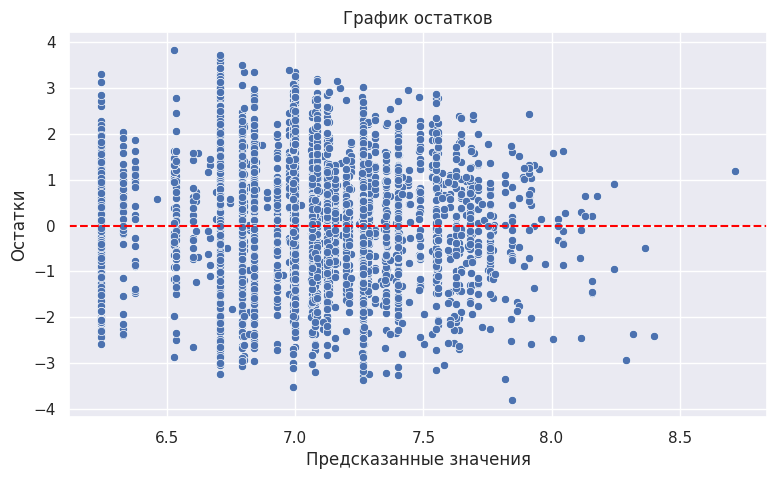

In [233]:
homoscedasticity(model)

Выглядит нестрашно + в результатах модели есть значние Durbin-Watson = 1.988, которое в пределах (1, 2). Так что можно считать, что в данных выполнено условие гомоскедастичности.

Теперь посмотрим на остатки.
Prob (Omnibus) - это статистический тест, измеряющий вероятность нормального распределения остатков. В нашей модели Prob (Omnibus) = 0.000, то есть данные не распредлены нормально. Это очень грустно :( Наши выводы невалидны?
Посмотрим на гистограмму и qq-plot остатков.

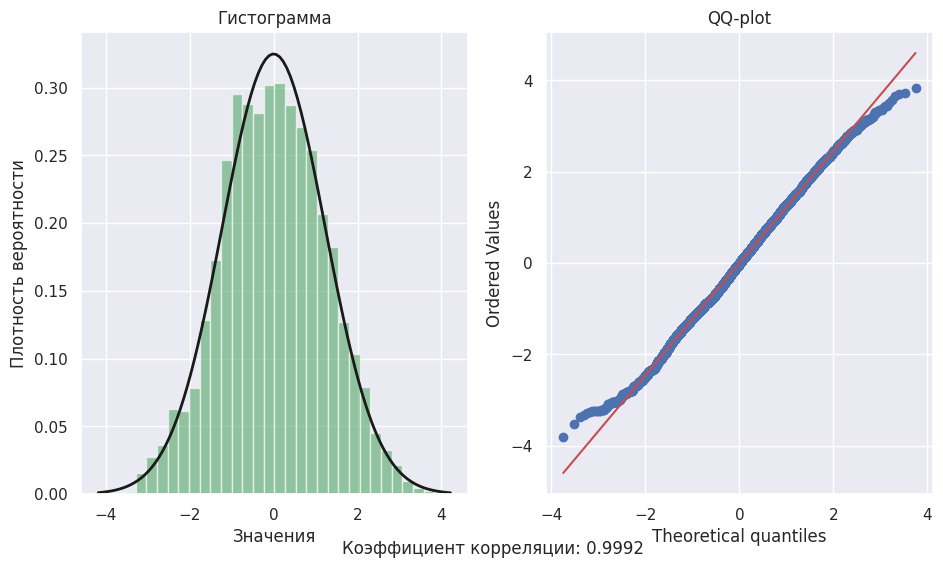

In [234]:
hist_and_qq_plot(model.resid)

Есть небольшая ассиметрия и на границах значений чуть больше, но в целом выглядит нестрашно. Известно, что тесты на нормальность очень чувствительны к малейшим отклонениям при большом количестве элементов + коэффициент корреляции по qq-plot равен 0.9992 > 0.95, так что это допустимое отклонение реальных данных от нормальных.




Следовательно, все условия к данным для линейной регрессии выполнены, так что модель валидна.

Теперь построим линрег для статистически значимых взаимодействий.

In [235]:
X = data_price_st.iloc[:, 1:]
y = data_price_st.iloc[:, 0]
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     46.78
Date:                Fri, 23 Aug 2024   Prob (F-statistic):           8.33e-48
Time:                        00:24:33   Log-Likelihood:                -12763.
No. Observations:                7783   AIC:                         2.554e+04
Df Residuals:                    7777   BIC:                         2.558e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

Посмотрим на результаты.
1. Самое главное: p-value комбинаций и F-статистики мало и можем откинуть нулевую гипотезу. Модель значима.
2. Adj. R-squared = 0.029, то есть эта модель определяет всего 2.9% вариативности зависимой переменной :(
3. intercept почти такой же как в первой модели, но чуть меньше (там 6.99, тут 6.85)
4. glicerin в сочетании с кислотами (lactic и glycolic) влияет отрицательно на стоимость продукта, в то время как с витамином C, церамидами и пептидами влияет положительно. Видимо витамин  С, церамиды и пептиды оказывают более сильное влияние на стоимость, чем глицерин; и суммарное влияние группы вносит положительный вклад в стоимость. Интересно тогда, почему не было статистически значимой группы vitamin_c::lactic::salicylic (то есть без глицерина), потому что тогда она должна более выражено влиять на стоимость (глицерин не давал бы свой отрицательный вклад)? Возможно потому что эти компоненты часто используются в производстве в совокупности из-за композиции полезных действ (усиливают друг друга).
5. Как и в прошлой модели пептиды и церамиды вносят хороший положительный вклад в стоимость. Тут правда они вносят вклад вместе с витамином С, хотя в прошлой модели витамин Е был весомее, чем С. Возможно это тоже связано с тем, что компоненты используют вместе при производстве для улучшения действия продукта по уходу за кожей.


По новым предикторам данные так же слабо коррелируют между друг другом (см. матрицу корреляций в 4.1) + Durbin-Watson = 1.989 + для остатков: r = 0.9991 (см. output ниже), так что требования к данным выполнены.


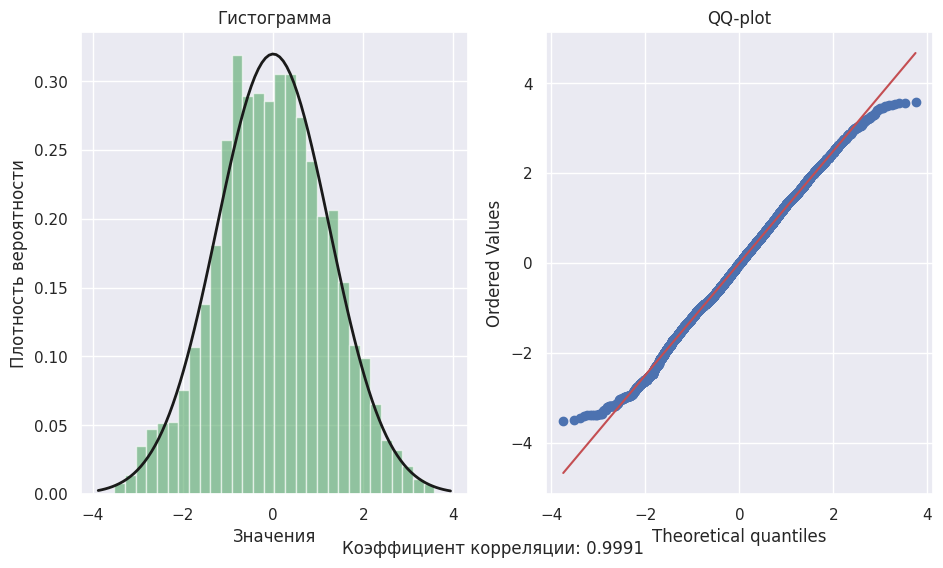

In [236]:
hist_and_qq_plot(model.resid)

# 4.3. Выводы


1. intercept логарифма от цены равен 6.85-7.0, то есть базовая цена без активных компонентов 943-1016 рублей.
2. Построенные модели объясняют вариативность зависимой переменной всего на 2.9-5.8%.
2. Наличие в составе кислот (отдельно от всего) статистически не влияет на стоимость продукта.
3. Глицерин и парабены вляют на стоимость продукта в отрицательную сторону. Парабены являются консервантами, так что видимо используются в дешевых некачественных продуктак для увеличения срока годности. Глицерин же в сочетании с кислотами отрицательно влияет, но в сочетании с витамином С, пептидами и церамидами влияет положительно (видимо из-за вклада последних).
4. Витамины C, E, A влияют положительно на стоимоть: + 0.26-0.60 к log_price, то есть в 1.3-1.8 раз увеличивают стоимость продукта относительно базовой.
5. Нациамид (в отрыве от остальных активных компонентов) увеличивает стоимось продукта в 1.14 раз, церамиды - в 1.43 раза, пептиды - в 1.75 раз.
6. Пептиды, церамиды сочетаются с витамином С и глицерином и статистически значимо влияют на стоимось продукта, увеличивая ее относительно базовой в 1.82 раза. Продукты с сочетанием витамина С, глицерина, молочной и салициловой кислоты -- в 2.7 раз (ого!); причем вляние на "стоимость" компонентов по отдельности несильное, то есть нельзя сказать, что эти продукты сами "дорогие"; возможно это сочетание активных компонентов является самым действенным в уходе за кожой, а поэтому и дорогим (посмотрим на него в анализе влияния на рейтинг).

# 5. Анализ влияния активных компонентов на рейтинг

Описание проделывемых шагов, их логики и смысла, можно найти в реализации анализа вляния активных компонентов в составе на стоимость продукта (пункт 4). Далее помечания будут содержать в основном те или иные выводы и только основные тезисы.

In [237]:
data_rating36_review10 = data[(data['rating'] >= 3.6) & (data['review_count'] > 10)]
data_rating36_review30 = data[(data['rating'] >= 3.6) & (data['review_count'] > 30)]
data_rating40_review10 = data[(data['rating'] >= 4.0) & (data['review_count'] > 10)]
data_rating40_review30 = data[(data['rating'] >= 4.0) & (data['review_count'] > 30)]

In [238]:
data_rating36_review10.shape[0]

1650

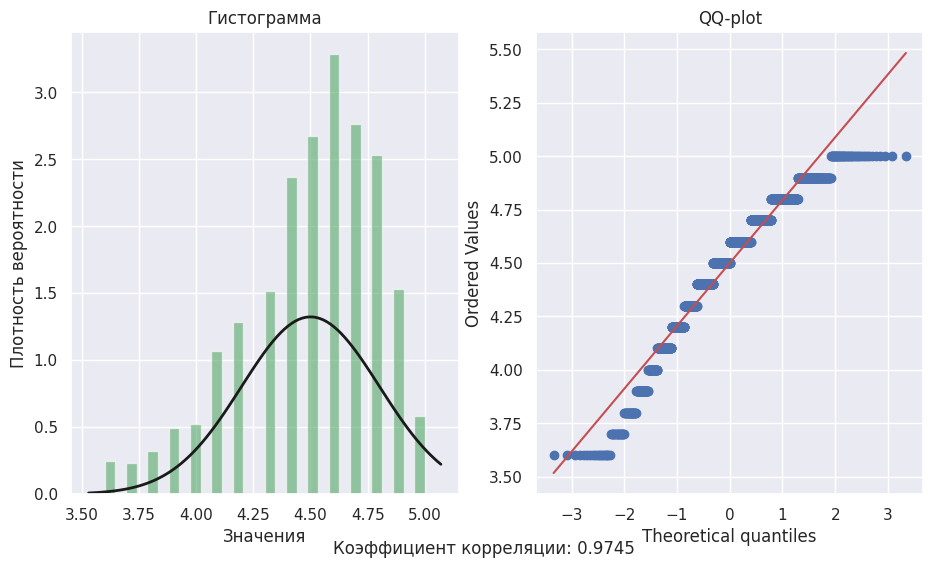

In [239]:
hist_and_qq_plot(data_rating36_review10['rating'])

In [240]:
data_rating36_review30.shape[0]

574

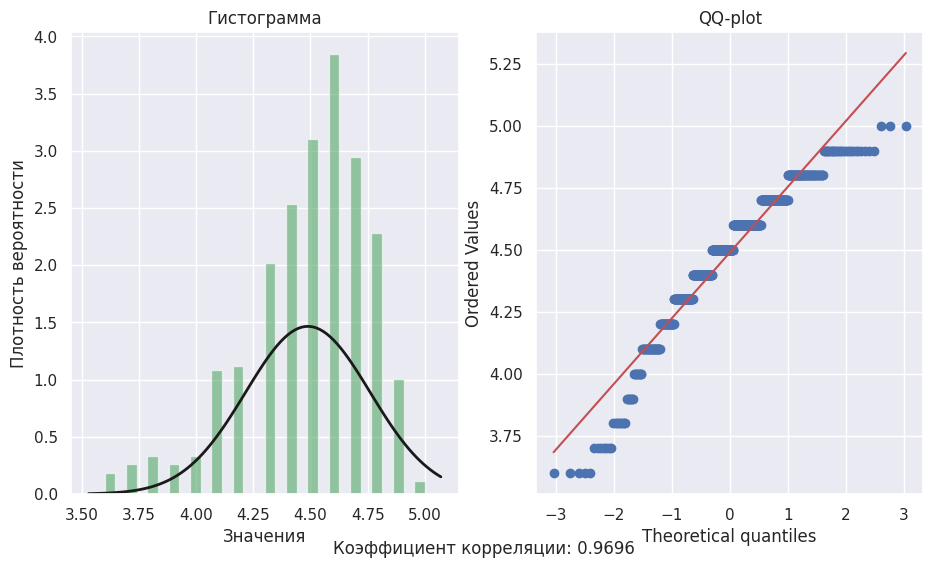

In [241]:
hist_and_qq_plot(data_rating36_review30['rating'])

In [242]:
data_rating40_review10.shape[0]

1550

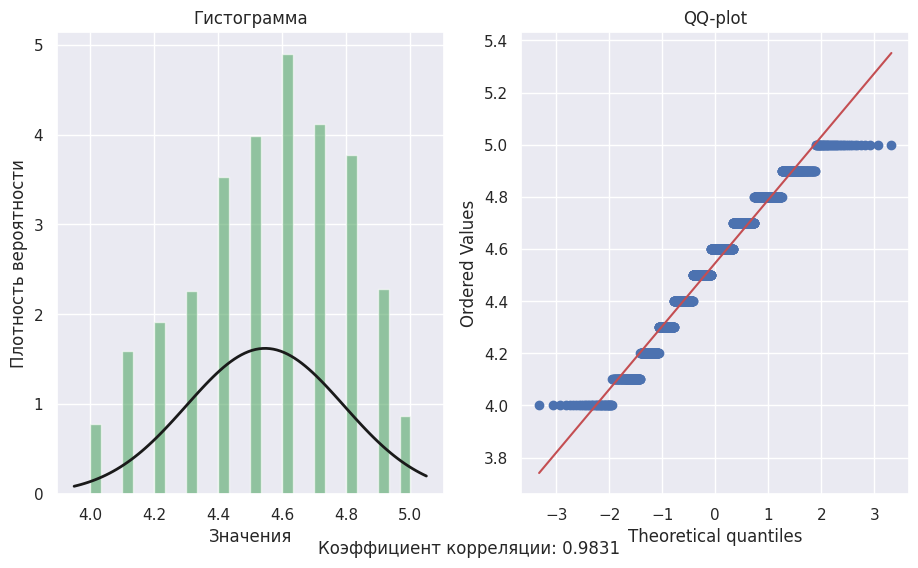

In [243]:
hist_and_qq_plot(data_rating40_review10['rating'])

In [244]:
data_rating40_review30.shape[0]

546

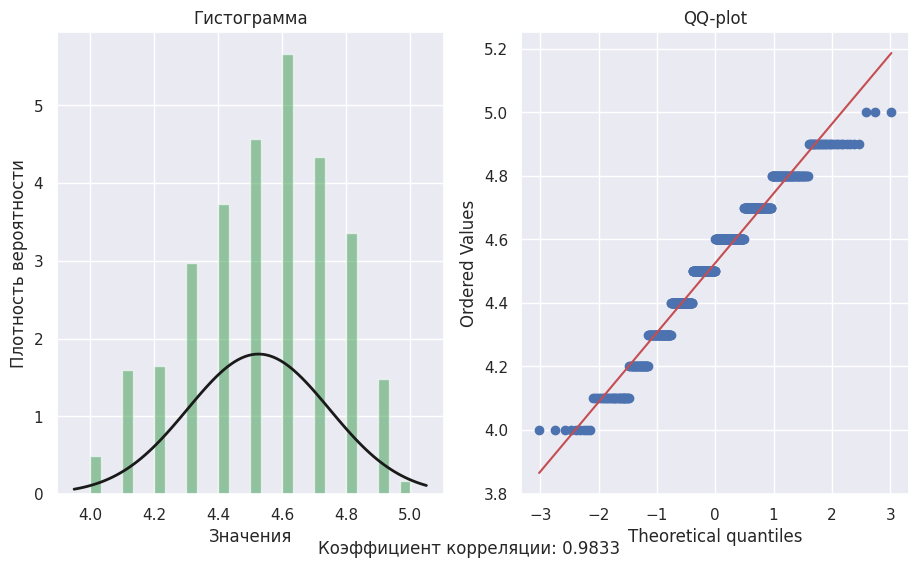

In [245]:
hist_and_qq_plot(data_rating40_review30['rating'])

Лучше отсечка по рейтингу в 4.0. Внутри нее распределения при Review_Count > 10 и Review_Count > 30 почти не отличаются, в то время как размер первой выборки в 3 раза больше, так что оставим ограничение в Review_Count > 10.

In [246]:
data = data_rating40_review10

Теперь проделаем аналогичную пункту 4 последовательность процедур.

## 5.1. Cтатистическая значимость по t-критерию Стьюдента

Подготовим данные к проведению теста о статистически значимой разнице средних значений рейтинга между базовой группой и группами с комбинацией активных компонентов.

In [247]:
data_rating = get_data_on_ingredients_and_dependent_variable('rating')
components = ALL_COMPONENTS.copy()

In [248]:
data_rating_comb = get_combinations(data_rating, components, 'rating')
data_rating_comb.head()

,combination,rating
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[4.9, 4.3, 4.9, 4.6, 4.0, 4.5, 4.7, 4.4, 4.1, ..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[4.7, 4.8, 4.9, 4.9, 4.8, 4.7, 4.5]"
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[4.5, 4.5, 4.6, 4.5, 4.7, 4.6, 4.9, 4.2, 4.3, ..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]","[4.1, 4.2]"
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]","[4.3, 4.4, 4.0, 4.2, 4.0, 4.0, 4.4, 4.7, 4.0]"


In [249]:
data_rating_comb.shape

(200, 2)

In [250]:
data_rating_comb = add_column_cnt_to_data_comb(data_rating_comb, 'rating')
data_rating_comb.shape

(63, 3)

In [251]:
data_rating_comb.head()

,combination,rating,cnt_products
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[4.9, 4.3, 4.9, 4.6, 4.0, 4.5, 4.7, 4.4, 4.1, ...",126
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[4.7, 4.8, 4.9, 4.9, 4.8, 4.7, 4.5]",7
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[4.5, 4.5, 4.6, 4.5, 4.7, 4.6, 4.9, 4.2, 4.3, ...",11
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]","[4.3, 4.4, 4.0, 4.2, 4.0, 4.0, 4.4, 4.7, 4.0]",9
5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]","[4.4, 4.6, 4.2]",3


In [252]:
base_group = get_base_group(data_rating_comb, 'rating')

In [253]:
data_rating_comb = data_rating_comb.drop(index=0)

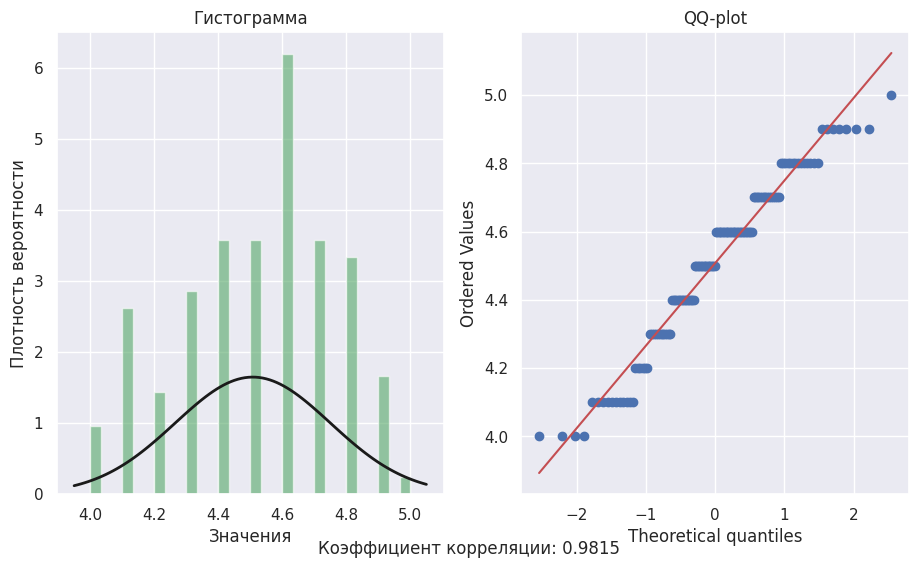

In [254]:
hist_and_qq_plot(base_group['rating'])

In [255]:
mean_rating = base_group['rating'].mean()
print(mean_rating)

4.507936507936508


In [256]:
data_rating_comb = filter_normal_distribution(data_rating_comb, 'rating')
data_rating_comb.shape

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


(53, 3)

In [257]:
alpha = 0.05 / (data_price_comb.shape[0] - 1)
print(alpha)

0.00036231884057971015


In [258]:
stats_ttest_rating_hard = get_statistically_significant_by_ttest(data_rating_comb, 'rating', mean_rating, alpha)
print(stats_ttest_rating_hard[0])

components                                                        rating
--------------------------------------------------------------  --------
vitamin_c::hyaluronic_acid::lactic_acid::glycerin::niacinamide       4.6


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Всего одна группа, которая значимо отличается от базовой. Если же мы сделаем ограничение на alpha более мягким, то получим

In [259]:
stats_ttest_rating_soft = get_statistically_significant_by_ttest(data_rating_comb, 'rating', mean_rating, 0.01)
print(stats_ttest_rating_soft[0])

components                                                        rating
--------------------------------------------------------------  --------
zinc                                                             4.75714
paraben                                                          4.22222
glycerin::peptide::niacinamide                                   4.73636
glycerin::ceramide                                               4.61282
glycerin::ceramide::peptide                                      4.68333
vitamin_c::hyaluronic_acid::lactic_acid::glycerin::niacinamide   4.6


6 групп. При этом все комбинации, указанные выше, кроме парабенов, положительно влияют на рейтинг.


In [260]:
data_rating_st_hard = data_rating.drop(columns=set(ALL_COMPONENTS).difference(stats_ttest_rating_hard[1]))
data_rating_st_soft = data_rating.drop(columns=set(ALL_COMPONENTS).difference(stats_ttest_rating_soft[1]))

In [261]:
df = pd.DataFrame(data_rating_st_hard)
df['group_vitamin_c_hyaluronic_lactic_glycerin_niacinamide'] = (df['vitamin_c'] & df['hyaluronic_acid'] & df['lactic_acid'] & df['glycerin'] & df['niacinamide']).astype(int)
data_rating_st_hard = df[['rating', 'group_vitamin_c_hyaluronic_lactic_glycerin_niacinamide']]

df = pd.DataFrame(data_rating_st_soft)
df['group_zinc'] = df['zinc']
df['group_paraben'] = df['paraben']
df['group_glycerin_peptide_niacinamide'] = (df['niacinamide'] & df['glycerin'] & df['peptide']).astype(int)
df['group_glycerin_ceramide'] = (df['glycerin'] & df['ceramide']).astype(int)
df['group_glycerin_ceramide_peptide'] = (df['glycerin'] & df['ceramide'] & df['peptide']).astype(int)
df['group_vitamin_c_hyaluronic_lactic_glycerin_niacinamide'] = (df['vitamin_c'] & df['hyaluronic_acid'] & df['lactic_acid'] & df['glycerin'] & df['niacinamide']).astype(int)
data_rating_st_soft = df[['rating',
                 'group_zinc',
                 'group_paraben',
                 'group_glycerin_peptide_niacinamide',
                 'group_glycerin_ceramide',
                 'group_glycerin_ceramide_peptide',
                 'group_vitamin_c_hyaluronic_lactic_glycerin_niacinamide']]

<Axes: >

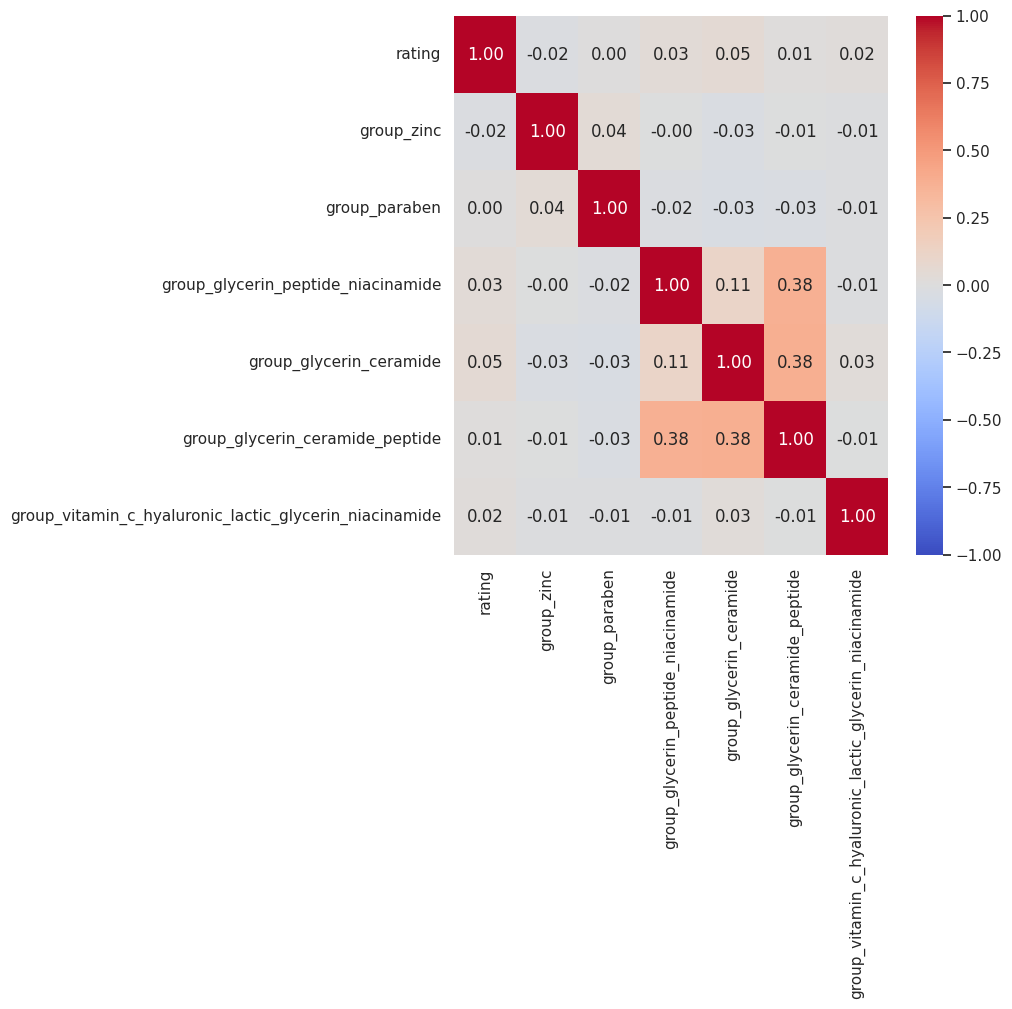

In [262]:
plt.subplots(figsize=(7, 7))
sns.heatmap(data_rating_st_soft.corr(), annot=True, fmt=".2f", vmin=-1, vmax=1, center= 0, cmap='coolwarm')

Уберем из data_rating_st_soft группу group_glycerin_ceramide_peptide, так как она коррелирует с двумя другими (что в целом логично, потому что она представляет собой набор компонентов из них).

<Axes: >

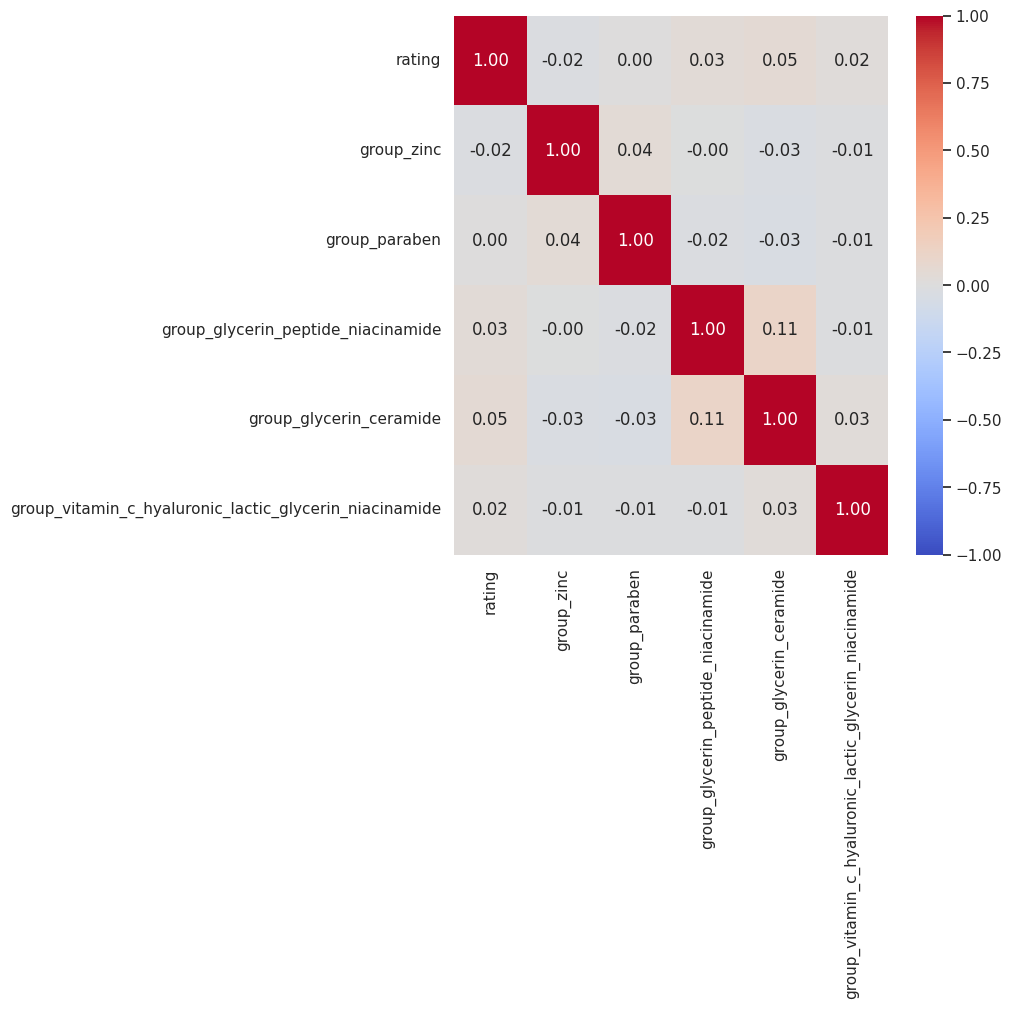

In [263]:
data_rating_st_soft = data_rating_st_soft.drop(columns=['group_glycerin_ceramide_peptide'])

plt.subplots(figsize=(7, 7))
sns.heatmap(data_rating_st_soft.corr(), annot=True, fmt=".2f", vmin=-1, vmax=1, center= 0, cmap='coolwarm')

## 5.2. Линейная регрессия

Аналогично сначала посмотроим модель на всех активных компонентах, уберем некоторые нерелевантные компоненты, и оценим эту модель. Потом построим модель на множествах взаимодействий компонентов, которые являются статистически значимыми из пункта 5.1. Сравним их и сдлеаем итоговые выводы о линейном влияниии актиных компонентов на рейтинг продукта.

In [264]:
X = data_rating.iloc[:, 1:]
y = data_rating.iloc[:, 0]
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     2.350
Date:                Fri, 23 Aug 2024   Prob (F-statistic):            0.00246
Time:                        00:25:05   Log-Likelihood:                -8.9460
No. Observations:                1550   AIC:                             49.89
Df Residuals:                    1534   BIC:                             135.4
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               4.5116      0.016    2

In [265]:
data_rating = data_rating.drop(columns=['vitamin_c', 'vitamin_e', 'retinol', 'hyaluronic_acid',
                                        'azelaic_acid', 'lactic_acid', 'mandelic_acid', 'glycolic_acid',
                                        'salicylic_acid', 'ceramide', 'paraben', 'zinc'])

In [266]:
X = data_rating.iloc[:, 1:]
y = data_rating.iloc[:, 0]
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     7.244
Date:                Fri, 23 Aug 2024   Prob (F-statistic):           7.95e-05
Time:                        00:25:05   Log-Likelihood:                -15.736
No. Observations:                1550   AIC:                             39.47
Df Residuals:                    1546   BIC:                             60.86
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.5081      0.016    285.055      

Prob (F-statistic) = 7.95e-05, ура! Но Durbin-Watson = 2.063, выполнена ли гомоскедастичность?

In [267]:
white_test = het_white(model.resid, model.model.exog)
labels = ['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value']
print(dict(zip(labels, white_test)))

{'LM Statistic': 5.57135235502485, 'LM p-value': 0.47287509746977563, 'F Statistic': 0.9276997782655475, 'F p-value': 0.4738297650387242}


p-value >> 0.05, то есть недостаточно оснований для отказа от нулевой гипотезы (модель не имеет гетероскедастичности, то есть она гомоскедастична), и мы можем предположить, что дисперсия ошибок постоянна.

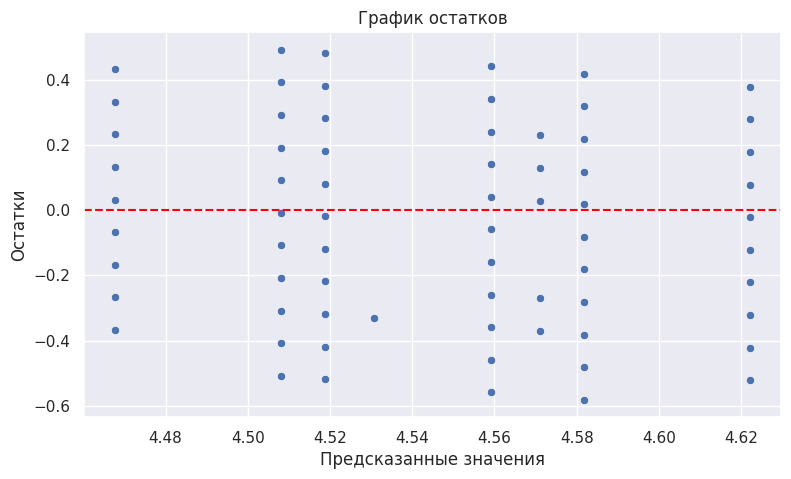

In [268]:
homoscedasticity(model)

По модулю того, что наши данные рейтинговые, а не непрерывные, условие гомоскедастичности выполнено.

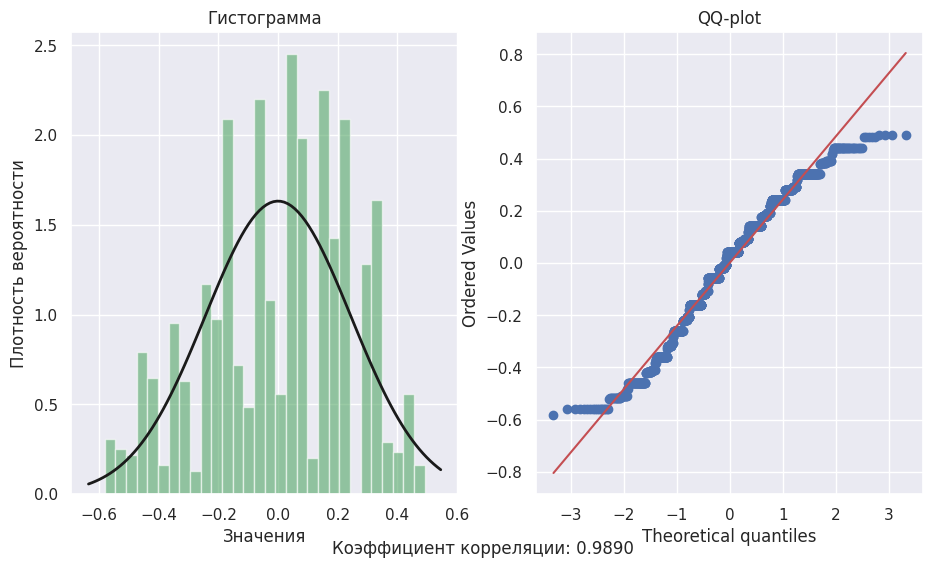

In [269]:
hist_and_qq_plot(model.resid)

Есть небольная ассиметрия и на границах распределние остатков не соотвествует нормальному, но коэффициент корреляции равен 0.98, следовательно, можем считать что условие нормальности выполнено. Итого, модель валидна, но определяет всего 1.2% дисперсии зависимой переменной.

Теперь посмотрим на наши множества взаимодействий компонентов.


In [270]:
X = data_rating_st_hard.iloc[:, 1:]
y = data_rating_st_hard.iloc[:, 0]
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4079
Date:                Fri, 23 Aug 2024   Prob (F-statistic):              0.523
Time:                        00:25:07   Log-Likelihood:                -26.349
No. Observations:                1550   AIC:                             56.70
Df Residuals:                    1548   BIC:                             67.39
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

Тут все очень-очень грустно:
* R-squared = 0.000
* Prob (F-statistic) = 0.523
* P>|t| (group_vitamin_c_hyaluronic_lactic_glycerin_niacinamide) = 0.523.

Модель не является статистически значимой.

In [271]:
X = data_rating_st_soft.iloc[:, 1:]
y = data_rating_st_soft.iloc[:, 0]
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.214
Date:                Fri, 23 Aug 2024   Prob (F-statistic):              0.300
Time:                        00:25:07   Log-Likelihood:                -23.512
No. Observations:                1550   AIC:                             59.02
Df Residuals:                    1544   BIC:                             91.10
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

Тут все тоже очень грустно:
* Prob (F-statistic) = 0.300
* P>|t| (для всех групп активных компонентов) > 0.05.


Итого, модель невалидна.

## 5.3. Выводы

Только первая из трех построеных моделей линейной регресии прошла проверку на валиднсть, является статистически значимой.

Нашли линейную зависимость рейтига от наличия трех компонентов:
$ rating = 4.5081 + 0.051 \cdot glycerin + 0.063 \cdot peptide - 0.0403 \cdot niacinamide$, однако она объясняет всего 1.2% диспресии зависимой переменной. :(

Линейной зависимости рейтинга от взаимодействия компонентов не нашли.

При проведении теста Стьюдента с поправкой Бонферрони группа из компонентов vitamin_c, hyaluronic_acid, lactic_acid, glycerin, niacinamide показала статистически значимые результаты со средним 4.6 (не такое большое различие, но предположим).

При более мягкой поправке (p-value < 0.01), были получены шесть групп, пять из которых согласуются с группами из пункта 4. Далее чуть подробнее об этих группах.
1. Цинк влияет на оценку продукта, но не вляет на стоимоть.
1. Парабены как консерватны негавино влияют на рейтинг и стоимость продукта.
2. Церамиды и пептиды влияют (вместе с глицерином!) в положительную сторону и на рейтинг, и на стоимость продукта.  
3. В анализе влияния на стоимоть была сильно влияющая группа vitamin_c::lactic_acid::salicylic_acid::glycerin, здесь мы получили группу vitamin_c::lactic_acid::hyaluronic_acid::glycerin::niacinamide, которая очень похожа. Так что наше преположение о том, что первая группа имеет очень высокую стоимоть не из-за самих компонентов, а из-за того что их композиция дает качетсвенный уход за кожей, звучит правдаподобно.
5. В предыдущих двух пунктах обсуждали группы, подмножество которых совпадает с группами из анализа влияния на стоимость. Тем не менее в них, в отличие от вторых, присутствует еще niacinamide. То есть наличие ниацинамида не делает группу "более значимой" по цене, но делает по качеству.

# 6. Анализ линейной зависимости стоимости и рейтинга продукта



In [272]:
data = data_rating40_review10

В EDA мы уже посмотрели, что связь рейтинга и цены выглядит линейной.


In [273]:
X = data['price_log']
y = data['rating']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4086
Date:                Fri, 23 Aug 2024   Prob (F-statistic):              0.523
Time:                        00:25:07   Log-Likelihood:                -26.349
No. Observations:                1550   AIC:                             56.70
Df Residuals:                    1548   BIC:                             67.39
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5192      0.043    104.968      0.0

Prob (F-statistic) = 0.523, следовательно, нельзя отклонить нулевую гипотезу о том, что рейтинг и стоимость продукта не связаны линейно.